<a href="https://colab.research.google.com/github/bhavya6701/comp473-project/blob/main/comp473_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Artistic Style Transfer Using Convolutional Neural Networks
**Authors:** Shibin Koshy [40295019], Ruturajsinh Vihol [40154693], Bhavya Manjibhai Ruparelia [40164863]

## Imports

In [32]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.optim as optim
from torchvision import transforms, models
from tqdm import tqdm
import warnings


In [33]:
# Filter out warnings
warnings.filterwarnings('ignore')

# Set the home directory
HOME = os.getcwd()

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Models

**VGG-16**: A convolutional neural network with 16 layers, popular for style transfer due to its ability to capture detailed hierarchical features across layers. Pre-trained on ImageNet, it offers a balance between depth and computational efficiency.

**VGG-19**: An extended version of VGG-16 with 19 layers, providing deeper feature representations. This model can capture more complex details, enhancing style extraction for artistic image synthesis.

<!-- **ResNet-50**: A 50-layer residual network with skip connections, which helps retain both high- and low-level features. This architecture is well-suited for extracting intricate textures and patterns in style transfer tasks. -->

In [34]:
# Load pre-trained models from torchvision
model_dict = {}

# VGG-16
model_dict["vgg-16"] = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features

# VGG-19
model_dict["vgg-19"] = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features

# For each model, freeze all the parameters
for model in model_dict.values():
    for param in model.parameters():
        param.requires_grad = False

    # Move the model to the specified device (GPU or CPU)
    model.to(device)

## Load Images

In [35]:
def load_image(img_path, max_size=400, shape=None):
    # Load in and transform an image, resize it, and convert it to a PyTorch tensor
    image = Image.open(img_path).convert("RGB")

    # Set target size based on max size or shape
    if shape is not None:
        target_size = shape
    else:
        target_size = min(max(image.size), max_size)

    # Define the transformation pipeline
    in_transform = transforms.Compose(
        [
            transforms.Resize(target_size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
            ),
        ]
    )

    image = in_transform(image)[:3, :, :].unsqueeze(0)

    return image


content = load_image(HOME + "/data/input_images/content6.jpeg").to(device)
style = load_image(HOME + "/data/input_images/style4.jpeg", shape=content.shape[-2:]).to(
    device
)

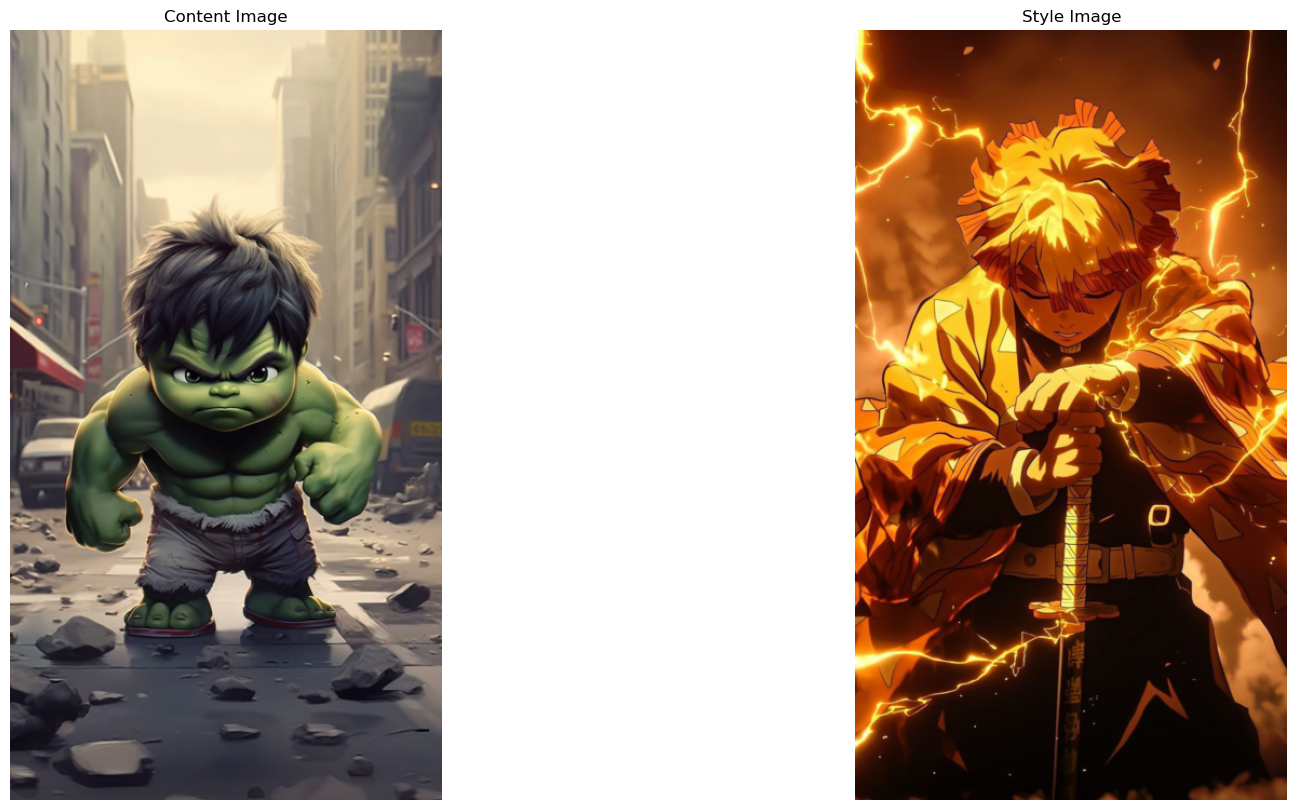

In [36]:
# Convert the images to numpy arrays
def tensor_to_image(tensor):
    # Invert normalization by reversing the mean and std
    denormalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
    )

    # Apply denormalization, convert to numpy, squeeze and transpose (C x H x W -> H x W x C)
    image = denormalize(tensor).cpu().numpy().squeeze().transpose(1, 2, 0)

    # Clip values to stay within the [0, 1] range
    return np.clip(image, 0, 1)


# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.title.set_text("Content Image")
ax1.imshow(tensor_to_image(content), label="Content")

ax2.title.set_text("Style Image")
ax2.imshow(tensor_to_image(style), label="Style")

# Remove the axes
ax1.axis("off")
ax2.axis("off")

plt.show()

## Feature Extraction and Gram Matrix

In [37]:
def extract_features(image, model, layers):
    features = {}
    x = image
    
    # Iterate through the model layers
    for name, layer in model.named_children():
        # Apply each layer to the image and store the result
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features


def gram_matrix(tensor):
    # Get the batch size, depth, height, and width of the tensor
    _, d, h, w = tensor.size()
    
    # Reshape the tensor to have the shape (depth, height * width)
    tensor = tensor.view(d, h * w)
    
    # Compute the Gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram.div(d * h * w)

## Loss Functions and Optimization

In [38]:
# Load the JSON file
with open("model_config.json", "r") as json_file:
    data = json.load(json_file)

# Extracting data into variables
layers = data["layers"]
model_style_weights = data["style_weights"]

## Training and Evaluation of Style Transfer Models

In [39]:
# Function to calculate the content loss
def calculate_content_loss(target_features, content_features, layer):
    return torch.mean((target_features[layer] - content_features[layer]) ** 2)


# Function to calculate the style loss
def calculate_style_loss(target_features, style_features, model_style_weights):
    style_loss = 0
    for layer, weight in model_style_weights.items():
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        target_gram = gram_matrix(target_feature)
        style_gram = gram_matrix(style_features[layer])
        layer_style_loss = weight * (torch.mean((target_gram - style_gram) ** 2))
        style_loss += layer_style_loss / (d * h * w)
    return style_loss


def initialize_target(content_img, method='content'):
    if method == 'content':
        return content_img.clone().requires_grad_(True)
    elif method == 'random':
        target = torch.randn_like(content_img).requires_grad_(True)
        target.data = target.data * 0.1 + 0.5
        return target
    else:
        raise ValueError("Method must be 'content' or 'random'")

# Function to show the images and total loss
def plot_images_graph(images, total_losses, steps, checkpoints):
    # Create a plot with 2 rows and 6 columns
    fig, axes = plt.subplots(2, 6, figsize=(18, 6))

    # Flatten axes for easy iteration
    axes = axes.flatten()
    for i, image in enumerate(images):
        title = (
            f"Iteration {i * (steps // checkpoints):,}"
            if i > 0 and i < len(images) - 1
            else "Initial Content (Noise)"
            if i == 0
            else "Final Image"
        )
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(title)

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Plot the total loss values
    plt.figure(figsize=(10, 5))
    plt.plot(total_losses, label="Total Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Total Loss")
    plt.title("Total Loss vs Iteration")
    plt.legend()
    plt.show()

In [40]:
# Compute the content and style featuref for the content and style images using the VGG-16 and VGG-19 models
content_features = {
    "vgg-16": extract_features(
        content, model_dict["vgg-16"], layers["vgg-16"]
    ),
    "vgg-19": extract_features(
        content, model_dict["vgg-19"], layers["vgg-19"]
    )
}
style_features = {
    "vgg-16": extract_features(style, model_dict["vgg-16"], layers["vgg-16"]),
    "vgg-19": extract_features(style, model_dict["vgg-19"], layers["vgg-19"])
}

In [ ]:
#  Function for the style transfer algorithm
def style_transfer_algorithm(
    model_name,
    content_loss_layer,
    iterations=500,
    lr=0.001,
    checkpoints=10,
    alpha=1,
    beta=1e2,
    init_method='random'
):
    model = model_dict[model_name]
    model_content_features = content_features[model_name]
    model_style_features = style_features[model_name]
    model_layers = layers[model_name]

    # Ensure that the content tensor is moved to the correct device and requires gradient
    target = initialize_target(style, method=init_method).to(device)

    # Define the optimizer
    optimizer = optim.Adam([target], lr=lr)

    # Create a list to store the images and the total loss values
    images = [tensor_to_image(target.detach())]
    total_losses = []
    print(beta)

    # Iterate through the steps
    for step in tqdm(range(1, iterations + 1)):
        # Extract the features from the target image
        target_features = extract_features(target, model, model_layers)

        # Calculate the content and style loss
        content_loss = calculate_content_loss(
            target_features, model_content_features, content_loss_layer
        )
        style_loss = calculate_style_loss(
            target_features, model_style_features, model_style_weights
        )

        # Compute the total loss
        total_loss = beta * content_loss + alpha * style_loss

        # Update the target image, zero the gradients, backpropagate, and step the optimizer
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Append the total loss to the list
        total_losses.append(total_loss.item())

        # Save the images at the specified checkpoints
        if step % (iterations // checkpoints) == 0:
            images.append(tensor_to_image(target.detach()))

    print(
        f"Step {step}/{iterations} - Total loss: {total_loss.item():.16f}, "
        f"Content loss: {content_loss.item():.16f}, Style loss: {style_loss.item():.16f}"
    )

    # Include the final image
    images.append(tensor_to_image(target.detach()))

    return images, total_losses

In [42]:
# Define hyperparameters and optimization settings
iterations = 100
checkpoints = 10
content_weight = 1e4
style_weight = 1e-2
lr = 0.1

## VGG-16 Style Transfer

In [43]:
# Call the style transfer function for the VGG-16 model
saved_images, total_losses = style_transfer_algorithm(
    "vgg-16", "conv2_1", iterations, lr, checkpoints, content_weight, style_weight, "content"
)

# Create a plot with the images and total loss values
plot_images_graph(saved_images, total_losses, iterations, checkpoints)

0.01


  9%|▉         | 9/100 [00:00<00:07, 12.09it/s]


KeyboardInterrupt: 

## VGG-19 Style Transfer

In [ ]:
# Call the style transfer function for the VGG-19 model
saved_images, total_losses = style_transfer_algorithm(
    "vgg-19", "conv2_1", iterations, lr, checkpoints, content_weight, style_weight, "content"
)

# Create a plot with the images and total loss values
plot_images_graph(saved_images, total_losses, iterations, checkpoints)

## Content Layer Comparison

In [ ]:
compare_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]
layer_images = []

# Iterate through the layers
for layer in compare_layers:
    print(f"Running style transfer for layer: {layer}")
    
    # Call the style transfer function for the VGG-19 model
    saved_images, total_losses = style_transfer_algorithm(
        "vgg-19", layer, iterations, lr, checkpoints, content_weight, style_weight, "content"
    )

    # Append the final image to the list
    layer_images.append(saved_images[-2])

# Create a plot with all the images obtained using different style_weight values
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, image in enumerate(layer_images):
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Layer {compare_layers[i]}")

plt.tight_layout()
plt.show()


## Style and Content Weight Analysis

In [ ]:
style_weights = [1e-8, 1e-4, 1, 1e4, 1e8]
lr = 0.1
output_images = []

# Call the style transfer function for the VGG-19 model
for style_weight in style_weights:
    print(f"Running style transfer algorithm with style weight = {style_weight}")
    saved_images, total_losses = style_transfer_algorithm(
        "vgg-19",
        "conv2_1",
        iterations,
        lr,
        checkpoints,
        content_weight,
        style_weight,
        "content"
    )
    
    output_images.append(saved_images[-2])

# Create a plot with all the images obtained using different style weight values
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, image in enumerate(output_images):
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Style weight = {style_weights[i]}")
    
plt.tight_layout()
plt.show()